In [1]:
import os
import yaml
import time
import torch 
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import joblib
from geopy.distance import geodesic
from torch.utils.data import DataLoader, TensorDataset, random_split 
import numpy as np
from scipy.special import boxcox1p, inv_boxcox

# Personnal function
from functions_models import point_space_boundaries
from functions_models.collect_mini_cubes import *
from functions_models.apply_transformation import apply_transformation
from functions_models.fill_nan_with_mean import fill_nan_with_mean
from functions_models.add_current import add_current
from functions_models.apply_bathy_mask import apply_bathy_mask
from functions_models.usefull_function_model import *
from functions_models.build_data_loader import build_data_loader
from functions_models.models_archi import *
from functions_models.create_new_training_folder import *
from functions_models.evaluate_model import *

In [2]:
def build_data_loader(image_size, model, pfts, device, batch_size, dataset, path_dico, threshold):
    
    space_buffer = int(image_size/2)
    path = f'./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}/'

    if model == 3:
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
    else : 
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)

    valid_mask = ~torch.isnan(df[:, 6])
    picture = picture[valid_mask]
    df = df[valid_mask]

    if model == 1:
        inputs = picture[:, 8:14, :, :].to(device)
    else:
        inputs = picture[:, :14, :, :].to(device)

   
    target = df[:, 5].to(device)
    if pfts:
        target = df[:, 6:9].to(device)
    set_column = df[:, 9].to(device)
    benchmark = df[:, 11].to(device)
    if pfts:
        benchmark = df[:, 12:15].to(device)

    train_mask = set_column == 0
    val_mask = set_column == 1
    test_mask = set_column == 2

    train_inputs = inputs[train_mask]
    train_target = target[train_mask]
    train_benchmark = benchmark[train_mask]

    # Data augmentation: ensure low_target and high_target each represent 5% of the training data
    data_augmentation = False
    if data_augmentation:
            total_samples = len(train_target)
            print("Total samples before augmentation:", total_samples)
    
            nb_groups = 5
            bin_edges = torch.linspace(train_target.min(), train_target.max(), steps=nb_groups+1).to(train_target.device)
            bin_indices = torch.bucketize(train_target, bin_edges, right=True) - 1 
    
            frequencies = torch.bincount(bin_indices).float()
            frequencies[frequencies == 0] = 1e-6  # éviter la division par 0
    
            duplication_factors = (1.0 / frequencies**0.5)
            duplication_factors *= (total_samples / duplication_factors.sum())  # normalisation globale
            duplication_factors = duplication_factors.int()
    
            augmented_inputs, augmented_targets, augmented_benchmarks = [], [], []
    
            for bin_id in range(10):
                mask = bin_indices == bin_id
                num_duplicates = duplication_factors[bin_id].item()
    
                if num_duplicates > 0 and mask.sum() > 0:
                    augmented_inputs.append(train_inputs[mask].repeat(num_duplicates, 1, 1, 1))
                    augmented_targets.append(train_target[mask].repeat(num_duplicates))
                    augmented_benchmarks.append(train_benchmark[mask].repeat(num_duplicates))
    
            
            train_inputs = torch.cat([train_inputs] + augmented_inputs)
            train_target = torch.cat([train_target] + augmented_targets)
            train_benchmark = torch.cat([train_benchmark] + augmented_benchmarks)
    
            print("Total samples after augmentation:", len(train_target))

    train_dataset = TensorDataset(train_inputs, train_target, train_benchmark)
    valid_dataset = TensorDataset(inputs[val_mask], target[val_mask], benchmark[val_mask])
    test_dataset = TensorDataset(inputs[test_mask], target[test_mask], benchmark[test_mask])
    
    # In this case, we do not shuffle the train data.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Ajout : sortie TCHLA (colonne 5) pour chaque split, même si pfts=True
    train_tchla = df[train_mask, 5].to(device)
    val_tchla = df[val_mask, 5].to(device)
    test_tchla = df[test_mask, 5].to(device)

    return train_loader, valid_loader, test_loader, df, train_tchla, val_tchla, test_tchla




In [3]:
# ¨Parameters that you don't change
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = "from_pfts_study_reset17072025"
image_size = 16
date_buffer = 1
space_buffer = int(image_size/2)
threshold = 0.99
model = 1
pfts = True 

#Hyper parameters 
learning_rate = 7*10e-4
batch_size = 100
nb_epoch = 6000


nb_training = 1

# Parameters for scatter plot 
main_title = f'MLP on {image_size}x{image_size} km with optics input'
y_label_name = f'MLP'
model_save_name = "MLP_1.pth"


# Load data 
path_dico = f"./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}"
train_loader, valid_loader, test_loader, df_mini_cubes, train_tchla, val_tchla, test_tchla = build_data_loader(image_size, model, pfts, 'cpu', batch_size, dataset, path_dico, threshold)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model_dl.parameters(), lr=learning_rate)


In [1]:
# 1) Load the best TCHLA model, you can select the mode between 
    # 1 - Only Optics - best model in function of the validation score - 22
    # 2 - All Optics and physics - best model in function of the validation score - 11
    # 3 - Optics and physics selected by the method  - best model in function of the validation score -

mode = 1
login = "/home/elabourdette"
if mode == 1:
    num_model_tchla = 22 
    model_tchla_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_all_threshold_0.99_boxcox/model_1/space_buffer_8_date_buffer_1/tchla_[70]_lr_7x10e-4_batch_200/train_{num_model_tchla}/MLP_1.pth"
    model_dl_tchla = DNN(6, [70], 1, device,p=0) 
elif mode == 2:
    num_model_tchla = 11
    model_tchla_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_all_threshold_0.99_boxcox/model_2/space_buffer_8_date_buffer_1/tchla_[70]_lr_7x10e-4_batch_200/train_{num_model_tchla}/MLP_2.pth"
    model_dl_tchla = DNN(14, [100], 1, device,p=0) 
elif mode == 3:
    # For the moment this model is not the best configuration. I have to remake the training with the new points added by the features selection. 
    num_model_tchla = 10
    model_tchla_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process_select_variables/training_TCHLA_all_threshold_0.99/space_buffer_8_date_buffer_1/model_SST/train_{num_model_tchla}/MLP_SST.pth"
    model_dl_tchla = DNN(6, [100], 1, device,p=0) 

# Download the model 
model_dl_tchla.to(device)
checkpoint = torch.load(model_tchla_path, map_location=device)
model_dl_tchla.load_state_dict(checkpoint['model_state_dict'])
model_dl_tchla.eval().to(device)

# Make tchla prediction on all the dataset
prediction_train_tchla, prediction_val_tchla, prediction_test_tchla = [], [], []

with torch.no_grad():
    for loader, pred_list in zip([train_loader, valid_loader, test_loader], [prediction_train_tchla, prediction_val_tchla, prediction_test_tchla]):
        for images in loader:
            images = images[0].to(device)
            images[images == -10] = float('nan')
            images = images.nanmean(dim=(2, 3))
            outputs = model_dl_tchla(images.float())
            pred_list.append(outputs.view(-1).cpu().numpy())

prediction_train_tchla = torch.tensor(np.concatenate(prediction_train_tchla))
prediction_val_tchla = torch.tensor(np.concatenate(prediction_val_tchla))
prediction_test_tchla = torch.tensor(np.concatenate(prediction_test_tchla))


NameError: name 'DNN' is not defined

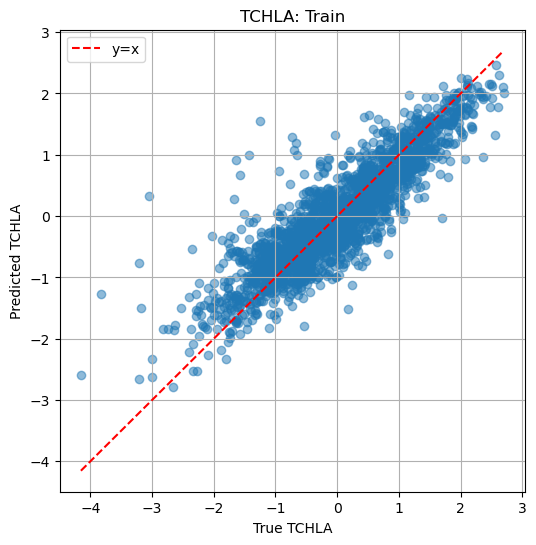

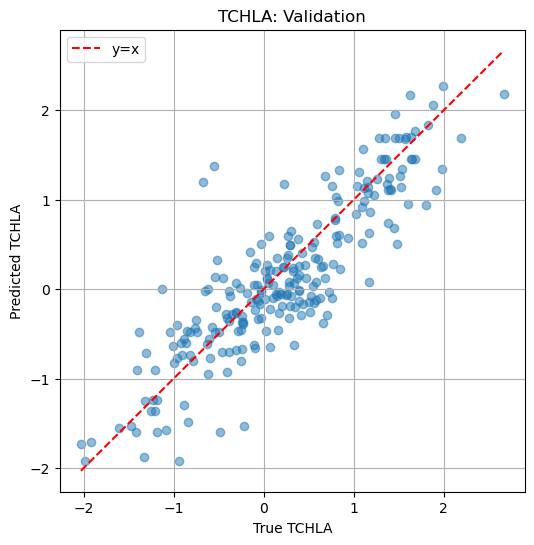

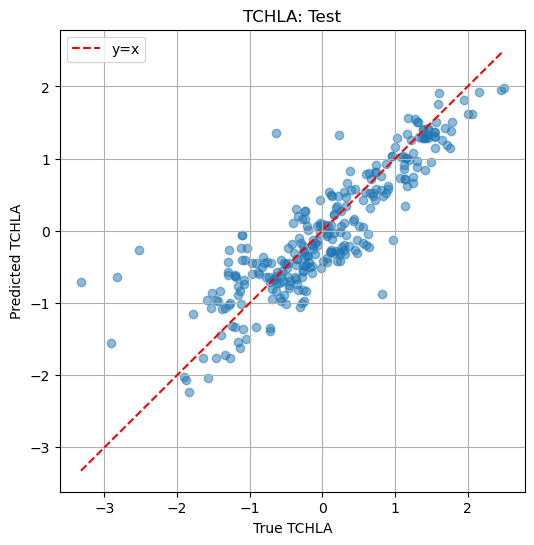

In [5]:
# Tracer les prédictions TCHLA vs vraies valeurs TCHLA pour chaque split
import matplotlib.pyplot as plt

def plot_tchla_vs_true(true, pred, split_name):
    plt.figure(figsize=(6,6))
    plt.scatter(true.cpu().numpy(), pred.cpu().numpy(), alpha=0.5)
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='y=x')
    plt.xlabel('True TCHLA')
    plt.ylabel('Predicted TCHLA')
    plt.title(f'TCHLA: {split_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_tchla_vs_true(train_tchla, prediction_train_tchla, 'Train')
plot_tchla_vs_true(val_tchla, prediction_val_tchla, 'Validation')
plot_tchla_vs_true(test_tchla, prediction_test_tchla, 'Test')


In [6]:
# 2) Create the model for PFTS prediction. This model make the prediction for only Micro and Nano Chla. 
#    We will then deduce the pico CHLA buy using Tchla - (Nano + Micro).
if mode == 1:
    model_dl = DNN(6, [70,50], 2, device,p=0.1) 
elif mode == 2:
    model_dl = DNN(14, [100,50], 2, device,p=0.3) 
elif mode == 3:
    print("not implemented yet")

model_dl.to(device)
optimizer = optim.Adam(model_dl.parameters(), lr=learning_rate)

In [7]:
import torch 
import copy
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_val_loop_l2(device, nb_epoch, model_dl, dataloader_train, dataloader_val,
                   optimizer, criterion, loss_diff_threshold, model, 
                   prediction_train_tchla, prediction_val_tchla,
                   pfts=False, patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4):
    """
    Custom training loop for PFTs prediction. Computes MSE for micro, nano, and pico.
    Inputs:
        prediction_train_tchla: tensor of TCHLA predictions for train set
        prediction_val_tchla: tensor of TCHLA predictions for val set
    """

    model_dl.to(device)

    LOSS_TRAIN = []
    LOSS_VAL = []
    list_val = []
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model_dl.state_dict())
    epoch_iterator = tqdm(range(nb_epoch), desc="Training epochs")

    for epoch in epoch_iterator:
        total_loss_train = 0
        model_dl.train()
        idx_train = 0
        for X_batch, Y_batch, __ in dataloader_train:
            if model != 3:
                X_batch[X_batch == -10] = float('nan')
                X_batch = X_batch.nanmean(dim=(2, 3))

            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            prediction = model_dl(X_batch.float())  # shape: [batch, 2] (micro, nano)
            micro_pred = prediction[:, 0].view(-1, 1)
            nano_pred = prediction[:, 1].view(-1, 1)
            tchla_pred = prediction_train_tchla[idx_train:idx_train+len(X_batch)].to(device).view(-1, 1)
            pico_pred = tchla_pred - micro_pred - nano_pred
            # Concaténer les trois prédictions
            prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
            #prediction_tensor = torch.cat([micro_pred, nano_pred], dim=1)
            truth_tensor = Y_batch[:, :3]  # micro, nano, pico

            # Appliquer le critère sur tout le tensor
            loss = criterion(prediction_tensor, truth_tensor)

            # Add L2 penalty
            if use_penalty and penalty_type == "L2":
                l2_penalty = sum(torch.sum(param**2) for param in model_dl.parameters())
                loss += penalty_lambda * l2_penalty

            loss.backward()
            total_loss_train += loss.item()
            optimizer.step()
            idx_train += len(X_batch)

        average_loss_train = total_loss_train / len(dataloader_train)
        LOSS_TRAIN.append(average_loss_train)

        if (epoch + 1) % 2 == 0:
            total_loss_val = 0
            model_dl.eval()
            idx_val = 0
            with torch.no_grad():
                for X_batch_val, Y_batch_val, __ in dataloader_val:
                    if model != 3:
                        X_batch_val[X_batch_val == -10] = float('nan')
                        X_batch_val = X_batch_val.nanmean(dim=(2, 3))

                    X_batch_val, Y_batch_val = X_batch_val.to(device), Y_batch_val.to(device)
                    prediction_val = model_dl(X_batch_val.float())
                    micro_pred = prediction_val[:, 0].view(-1, 1)
                    nano_pred = prediction_val[:, 1].view(-1, 1)
                    tchla_pred = prediction_val_tchla[idx_val:idx_val+len(X_batch_val)].to(device).view(-1, 1)
                    pico_pred = tchla_pred - micro_pred - nano_pred
                    # Concaténer les trois prédictions
                    prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
                    #prediction_tensor = torch.cat([micro_pred, nano_pred], dim=1)
                    truth_tensor = Y_batch_val[:, :3]
                    #truth_tensor = Y_batch_val[:, :2]

                    # Appliquer le critère sur tout le tensor
                    loss_val = criterion(prediction_tensor, truth_tensor)
                    total_loss_val += loss_val.item()
                    idx_val += len(X_batch_val)

            average_loss_val = total_loss_val / len(dataloader_val)
            LOSS_VAL.append(average_loss_val)
            list_val.append(average_loss_val)

            if average_loss_val < best_val_loss:
                best_val_loss = average_loss_val
                best_model_state = copy.deepcopy(model_dl.state_dict())

        if len(LOSS_TRAIN) >= patience and (epoch + 1) % 2 == 0:
            recent_losses = LOSS_VAL[-patience:]
            if max(recent_losses) - min(recent_losses) < loss_diff_threshold:
                print(f'Early stopping at epoch {epoch + 1} due to minimal change in validation loss over the last {patience} epochs')
                break

    model_dl.load_state_dict(best_model_state)

    return LOSS_TRAIN, LOSS_VAL, list_val, model_dl




In [8]:
loss_diff_threshold = 0.002
LOSS_TRAIN, LOSS_VAL, list_val, model_dl = train_val_loop_l2(device, nb_epoch, model_dl, train_loader, valid_loader,
                   optimizer, criterion, loss_diff_threshold, model, 
                   prediction_train_tchla, prediction_val_tchla,
                   pfts=False, patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4)

Training epochs: 100%|██████████| 6000/6000 [12:49<00:00,  7.80it/s]


./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/loss_MSE
Plot saved as:
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/loss_MSE.png
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/loss_MSE.pdf
Plot saved as:
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/loss_MSE.png
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/loss_MSE.pdf


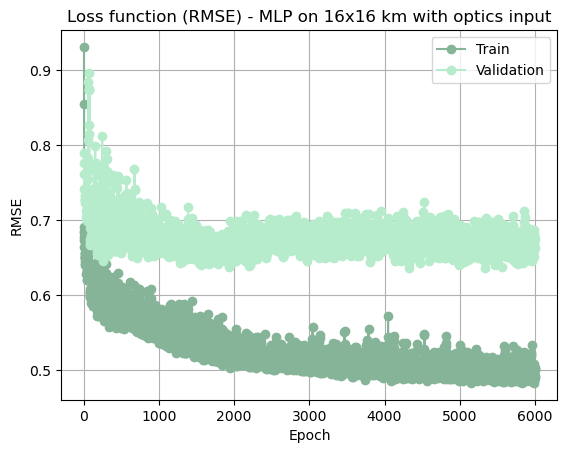

In [9]:
#make a save file 
training_name = "new_loss_pico_soustraction"
path_save = f"./training_{training_name}/model_{model}/space_buffer_{space_buffer}_date_buffer_{date_buffer}"
path_save_all = create_new_training_folder(path_save, pfts)
path_save_loss = os.path.join(path_save_all, "loss_MSE")
print(path_save_loss)
plot_loss(LOSS_TRAIN, LOSS_VAL, main_title, path_save_loss, "RMSD")

In [10]:
import os
import json
import torch
import joblib
import numpy as np
from scipy.special import inv_boxcox

def evaluate_model(dataloader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix, set_type, prediction_train_tchla=None, prediction_val_tchla=None, prediction_test_tchla=None):
    # Map pour filtrage selon set_type
    set_code_map = {'train': 0, 'val': 1, 'test': 2}
    set_code = set_code_map[set_type]

    # Sélectionner la bonne prédiction tchla selon le set
    if set_type == 'train':
        prediction_X_tchla = prediction_train_tchla
    elif set_type == 'val':
        prediction_X_tchla = prediction_val_tchla
    elif set_type == 'test':
        prediction_X_tchla = prediction_test_tchla
    else:
        raise ValueError(f"set_type inconnu: {set_type}")

    model_trained.eval()
    prediction_set = []
    true_set = []
    idx = 0

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            if model != 3:
                images[images == -10] = float('nan')
                images = images.nanmean(dim=(2, 3))
            outputs = model_trained(images.float())
            # Ajout de la prédiction pico
            micro_pred = outputs[:, 0].view(-1, 1)
            nano_pred = outputs[:, 1].view(-1, 1)
            tchla_pred = prediction_X_tchla[idx:idx+len(images)].to(device).view(-1, 1)
            pico_pred = tchla_pred - micro_pred - nano_pred
            # Concaténer micro, nano, pico
            all_pred = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
            prediction_set.append(all_pred.cpu())
            true_set.append(labels.cpu())
            idx += len(images)

    prediction_set = torch.cat(prediction_set, dim=0)
    true_set = torch.cat(true_set, dim=0)

    print(prediction_set.shape, true_set.shape)

    df_set = df_mini_cubes[df_mini_cubes[:, 9] == set_code]
    df_set_lat = df_set[:, 0]

    if pfts:
        keys = ["Micro_Chla", "Nano_Chla", "Pico_Chla"]
        short_keys = ["micro", "nano", "pico"]
    
        predictions = {}
        truths = {}
    
        # Charger le dico contenant les stats (mean/std, boxcox lambda)
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
    
        for i, key in enumerate(keys):
            short_key = short_keys[i]
            true_i = true_set[:, i].detach().cpu().numpy().reshape(-1, 1)
            pred_i = prediction_set[:, i].detach().cpu().numpy().reshape(-1, 1)
            if data_to_use == "quantile":
                # Charger quantile transformer
                transfo_path = os.path.join(path_dico, f"{key}_quantile_transformer.pkl")
                if not os.path.exists(transfo_path):
                   raise FileNotFoundError(f"Missing transformer: {transfo_path}")
                transformer = joblib.load(transfo_path)
    
                # Inverse quantile transform
                pred_i = transformer.inverse_transform(pred_i).flatten()
                true_i = transformer.inverse_transform(true_i).flatten()

            elif data_to_use == "boxcox": 
                # Déstandardisation
                mean = dico[f"{key}_standardization_mean"]
                std = dico[f"{key}_standardization_std"]
                pred_i = pred_i * std + mean
                true_i = true_i * std + mean
    
                # Déboxcox
                lmbda = dico[f"{key}_boxcox_lmbda"]
                pred_i = inv_boxcox(pred_i, lmbda)
                true_i = inv_boxcox(true_i, lmbda)

                # Thresholrd
                pred_i = pred_i - 10e-4
                true_i = true_i - 10e-4

            pred_i[pred_i < 0.0001] = 0.0001
            true_i[true_i < 0.0001] = 0.0001
            predictions[short_key] = pred_i.tolist()
            truths[short_key] = true_i.tolist()

        # Plot pour chaque PFT
        for pft in short_keys:
            x_label = f'HPLC {pft}-Chla (mg.m$^{{-3}}$)'
            y_label = f'{y_label_name} \n {pft}-Chla (mg.m$^{{-3}}$)'
            output_file = os.path.join(path_save_all, f'{pft}_{suffix}_plot.png')

            plot_score2(
                predictions[pft],
                truths[pft],
                main_title,
                df_set_lat,
                output_link=output_file,
                axis_log=True,
                xlabel=x_label,
                ylabel=y_label,
                PFTS=True
            )
    else:
        key = "TChla"
        short_key = "tchla"
    
        predictions = {}
        truths = {}
    
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
        prediction_set = prediction_set.cpu().numpy().reshape(-1, 1)
        true_set = true_set.cpu().numpy().reshape(-1, 1)

        if data_to_use == "quantile":
            # Charger quantile transformer
            TChla_path = os.path.join(path_dico, "TChla_quantile_transformer.pkl")
            quantile_transformer = joblib.load(TChla_path)

            predictions = quantile_transformer.inverse_transform(prediction_set)
            truths = quantile_transformer.inverse_transform(true_set)
        
        elif data_to_use == "boxcox": 
            # Déstandardisation
            mean = dico[f"{key}_standardization_mean"]
            std = dico[f"{key}_standardization_std"]
            pred_i = prediction_set * std + mean
            true_i = true_set * std + mean
    
            # Déboxcox
            lmbda = dico[f"{key}_boxcox_lmbda"]
            pred_i = inv_boxcox(pred_i, lmbda)
            true_i = inv_boxcox(true_i, lmbda)
    


        x_label = f'HPLC Total-Chla (mg.m$^{{-3}}$)'
        y_label = f'{y_label_name} \n Total-Chla (mg.m$^{{-3}}$)'
        output_file = os.path.join(path_save_all, f'tchla_{suffix}_plot.png')
        plot_score2(pred_i, true_i , main_title, df_set_lat, output_link=output_file, axis_log=True, xlabel=x_label, ylabel=y_label)


torch.Size([288, 3]) torch.Size([288, 3])


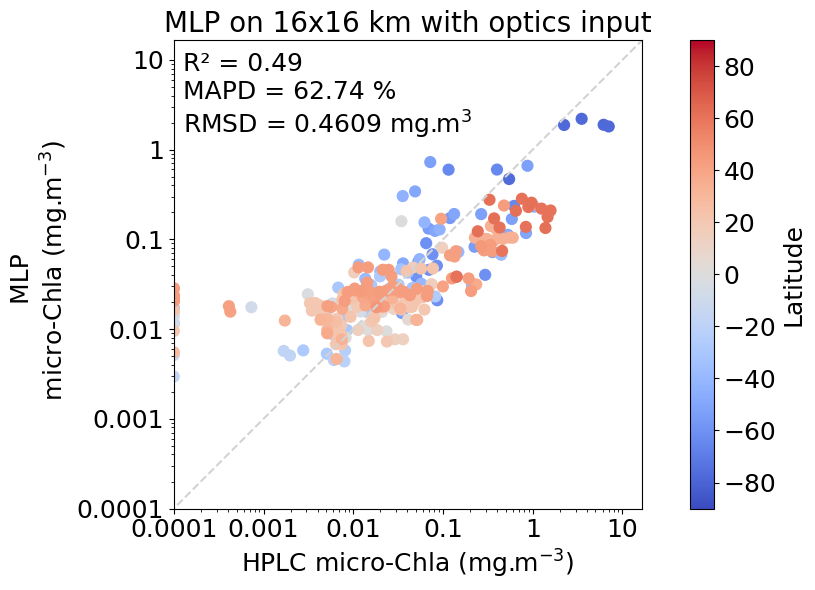

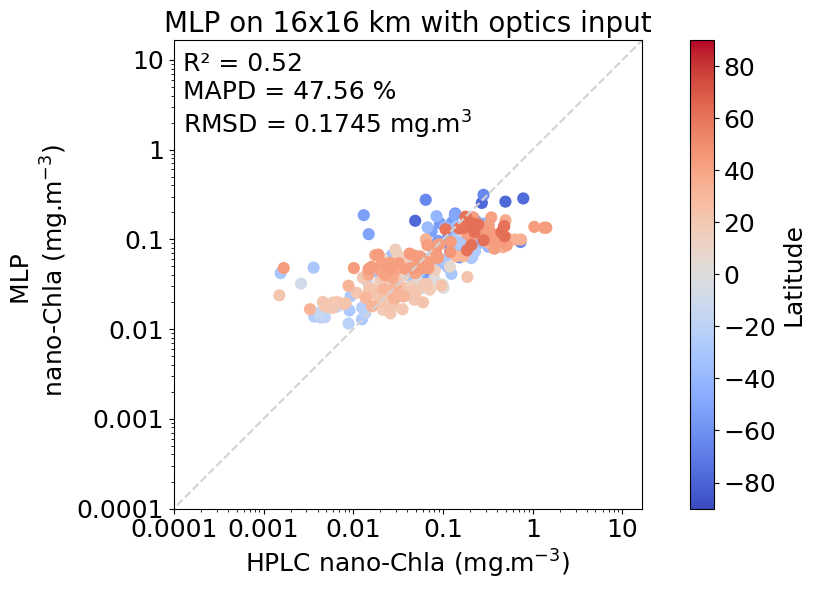

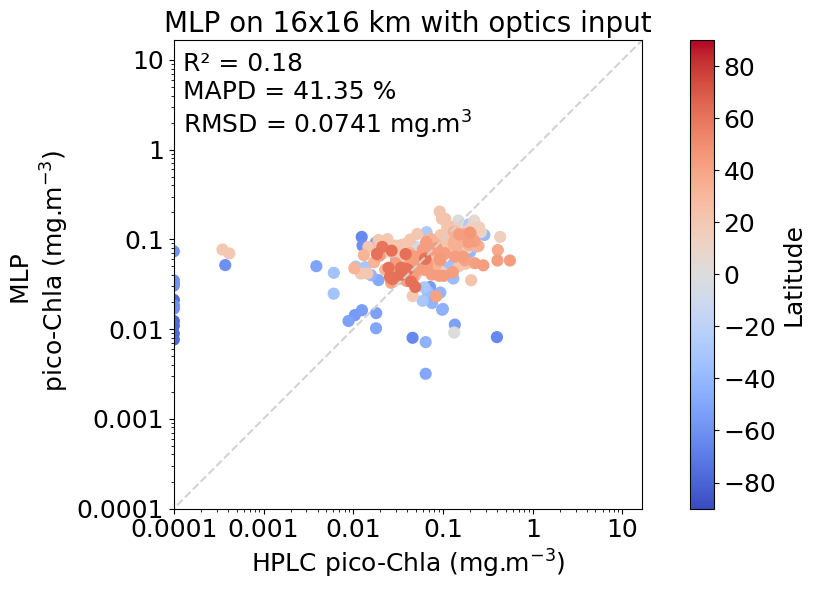

torch.Size([235, 3]) torch.Size([235, 3])


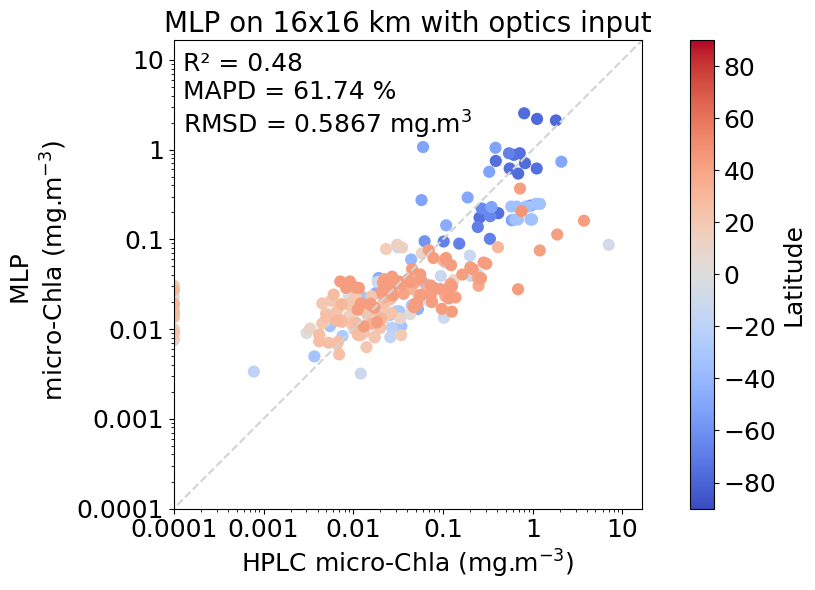

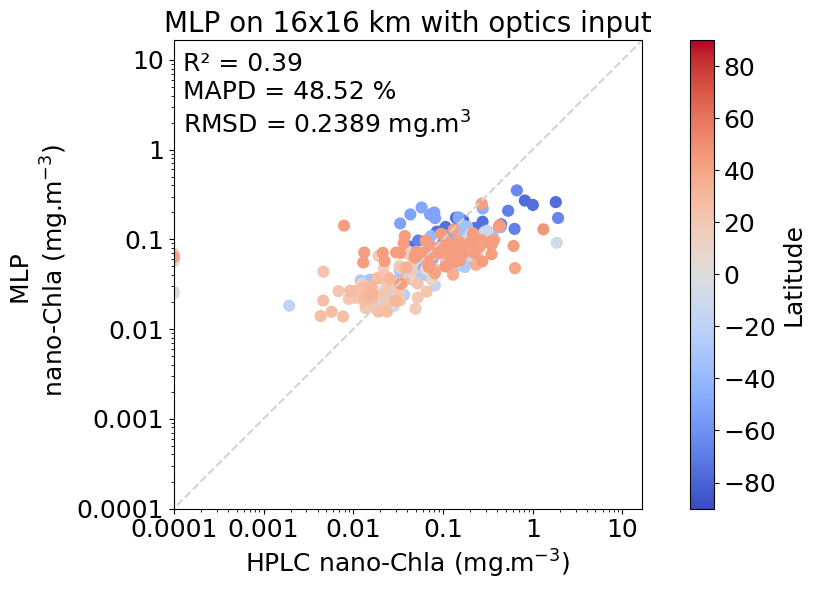

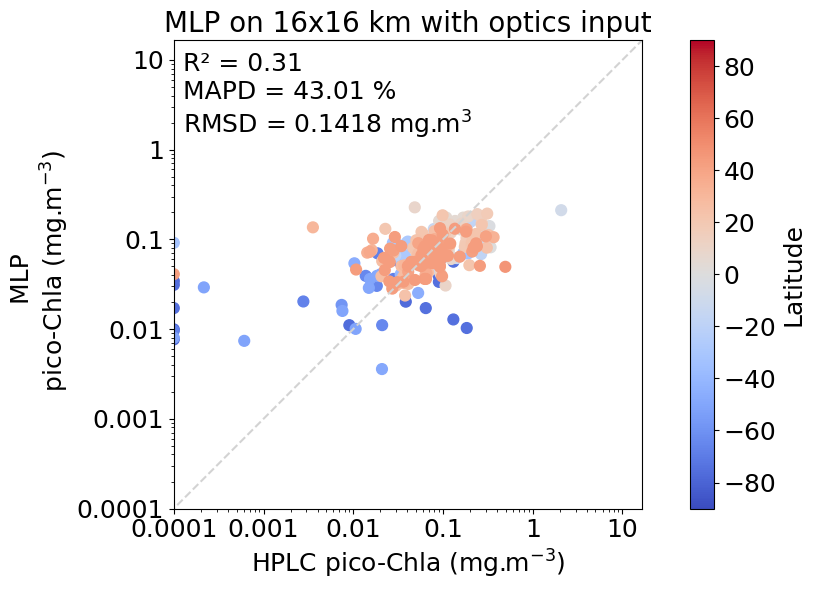

torch.Size([2207, 3]) torch.Size([2207, 3])


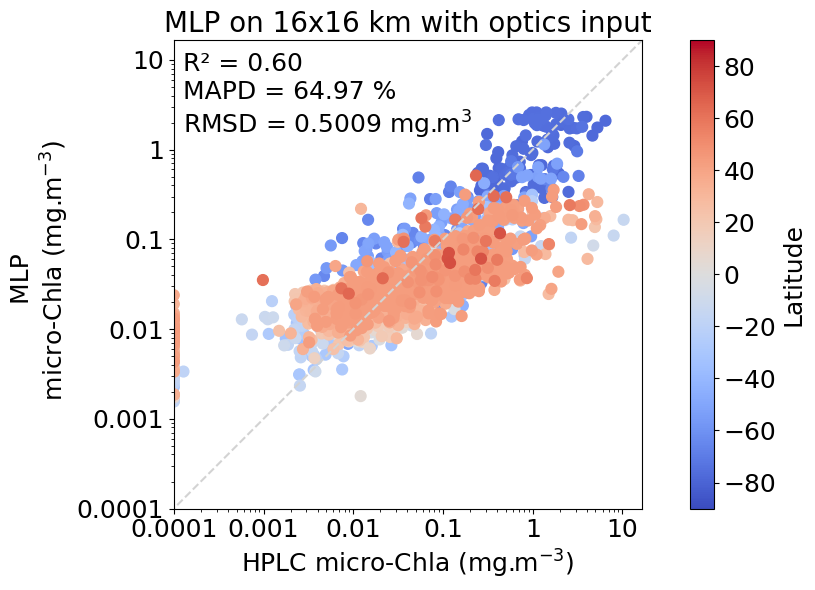

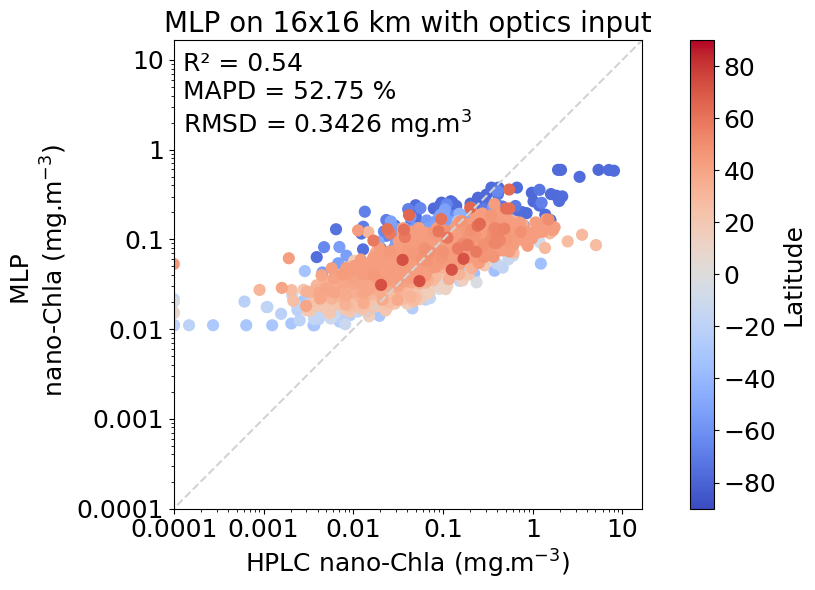

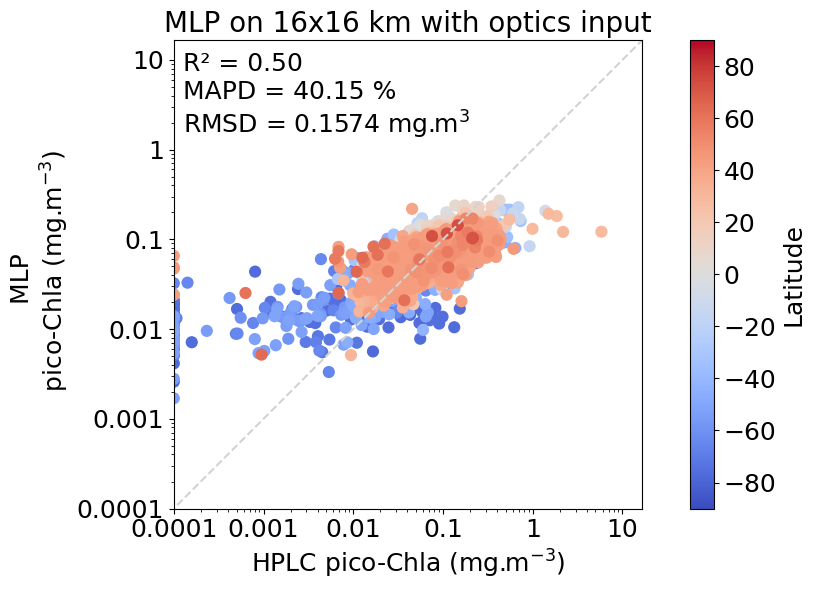

In [11]:
data_to_use = "boxcox"

evaluate_model(test_loader, model_dl, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="test", set_type="test", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)
evaluate_model(valid_loader, model_dl, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="val", set_type="val", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)
evaluate_model(train_loader, model_dl, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="train", set_type="train", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)


In [12]:
model_save_name = "MLP.pth"
model_save_path = os.path.join(path_save_all, model_save_name)
torch.save({
        'epoch': nb_epoch, 
        'model_state_dict': model_dl.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict() }, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_5/MLP.pth
